<a href="https://colab.research.google.com/github/FaridRash/IGNIS/blob/main/SNR_Final_Simulation_88k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/FaridRash/IGNIS

Cloning into 'IGNIS'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 202 (delta 70), reused 78 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (202/202), 23.98 MiB | 5.42 MiB/s, done.
Resolving deltas: 100% (70/70), done.
Updating files: 100% (30/30), done.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
df = pd.read_csv('/content/IGNIS/Dataset/snr_dataset_gpu_Tf_20800.csv')
print(df.head())

       Tg      Tf  theta       R  tau_a
0  283.15  413.15      0  460000    0.1
1  283.15  418.15      0  460000    0.1
2  283.15  423.15      0  460000    0.1
3  283.15  428.15      0  460000    0.1
4  283.15  433.15      0  460000    0.1


In [ ]:
df.shape

(104000, 5)

In [ ]:
def GSD(h):
  return (h * 0.000012 / 0.0728) ** 2

In [ ]:
df['GSD'] = df['R'].apply(GSD)
print(df.head())
print(df.tail())

       Tg      Tf  theta       R  tau_a          GSD
0  283.15  413.15      0  460000    0.1  5749.305639
1  283.15  418.15      0  460000    0.1  5749.305639
2  283.15  423.15      0  460000    0.1  5749.305639
3  283.15  428.15      0  460000    0.1  5749.305639
4  283.15  433.15      0  460000    0.1  5749.305639
            Tg      Tf  theta       R  tau_a         GSD
103995  373.15  413.15     24  150025   0.55  611.543007
103996  373.15  418.15     24  150025   0.55  611.543007
103997  373.15  423.15     24  150025   0.55  611.543007
103998  373.15  428.15     24  150025   0.55  611.543007
103999  373.15  433.15     24  150025   0.55  611.543007


In [ ]:
c1 = 3.7418e8
c2 = 1.4388e4
h = 6.626e-34
c = 3e8

In [ ]:
Af = 10*10
Tf = 433.15
epsilon = 0.95
tau_0 = 0.89
eta = 0.7
t = 0.01
focal_length = 72.8 / 1000
pixel = 12e-6
F_number = 1.05
D = (focal_length / F_number)

lambda_range = np.arange(8, 12.1, 0.1)
delta_lambda = 0.1

In [ ]:
def compute_snr_vectorized(df):
    Tg = df['Tg'].values[:, None]
    R = df['R'].values
    tau_a = df['tau_a'].values[:, None]
    theta = df['theta'].values
    GSD = df['GSD'].values

    Ag = GSD - Af
    cos_theta = np.cos(np.deg2rad(theta))

    lambda_ = lambda_range[None, :]

    # Planck radiation
    M_lambda_g = c1 / (lambda_**5 * (np.exp(c2 / (lambda_ * Tg)) - 1))
    M_lambda_f = c1 / (lambda_**5 * (np.exp(c2 / (lambda_ * Tf)) - 1))

    E_lambda_g = epsilon * M_lambda_g
    E_lambda_f = epsilon * M_lambda_f

    tau_factor = tau_a * tau_0 * eta * delta_lambda

    # Coefficients
    coeff_g = ((D**2 * t * cos_theta * Ag) / (4 * R**2 * h * c))[:, None]
    coeff_f = ((D**2 * t * cos_theta * Af) / (4 * R**2 * h * c))[:, None]

    S_lambda_g = coeff_g * (lambda_ * E_lambda_g * tau_factor)
    S_lambda_f = coeff_f * (lambda_ * E_lambda_f * tau_factor)

    S_Ag = np.sum(S_lambda_g, axis=1)
    S_Af = np.sum(S_lambda_f, axis=1)

    S_prime_g = S_Ag / Ag
    S_prime_f = S_Af / Af
    S_prime = S_prime_f - S_prime_g
    N_prime = np.sqrt(S_prime_f + S_prime_g)

    return S_prime / N_prime


In [ ]:
df['SNR'] = compute_snr_vectorized(df)

In [ ]:
chunks = np.array_split(df, 18)
snr_list = []
for i, chunk in enumerate(chunks):
    print(f"Processing chunk {i+1}")
    chunk['SNR'] = compute_snr_vectorized(chunk)
    snr_list.append(chunk)
df_final = pd.concat(snr_list, ignore_index=True)


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10
Processing chunk 11
Processing chunk 12
Processing chunk 13
Processing chunk 14
Processing chunk 15
Processing chunk 16
Processing chunk 17
Processing chunk 18


In [ ]:
df_final.head()

,Tg,Tf,theta,R,tau_a,GSD,SNR
0,283.15,413.15,0,460000,0.1,5749.305639,239512.546772
1,283.15,418.15,0,460000,0.1,5749.305639,239512.546772
2,283.15,423.15,0,460000,0.1,5749.305639,239512.546772
3,283.15,428.15,0,460000,0.1,5749.305639,239512.546772
4,283.15,433.15,0,460000,0.1,5749.305639,239512.546772


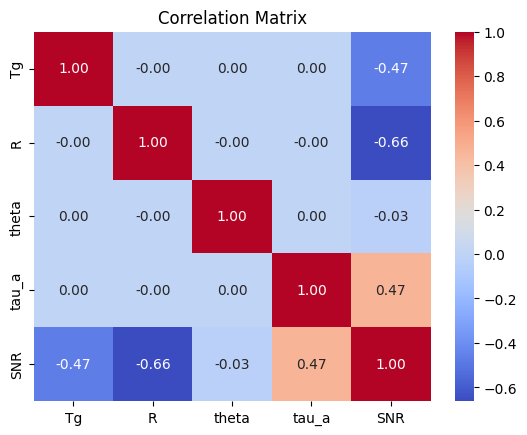

In [ ]:
correlation = df[['Tg', 'R', 'theta', 'tau_a', 'SNR']].corr()
sns.heatmap(correlation, fmt='.2f', annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

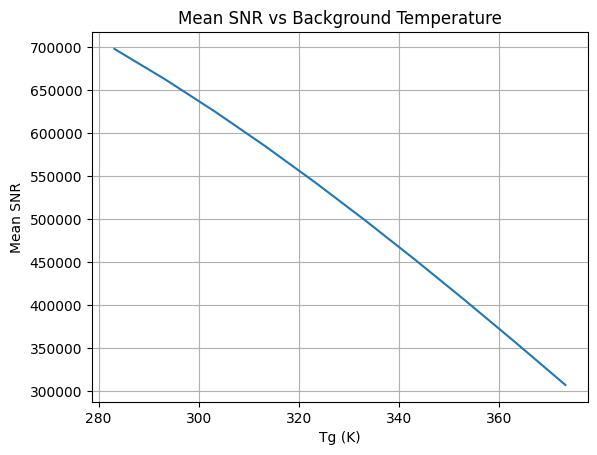

In [ ]:
df_grouped = df.groupby('Tg')['SNR'].mean().reset_index()

plt.plot(df_grouped['Tg'], df_grouped['SNR'])
plt.xlabel("Tg (K)")
plt.ylabel("Mean SNR")
plt.title("Mean SNR vs Background Temperature")
plt.grid(True)
plt.show()

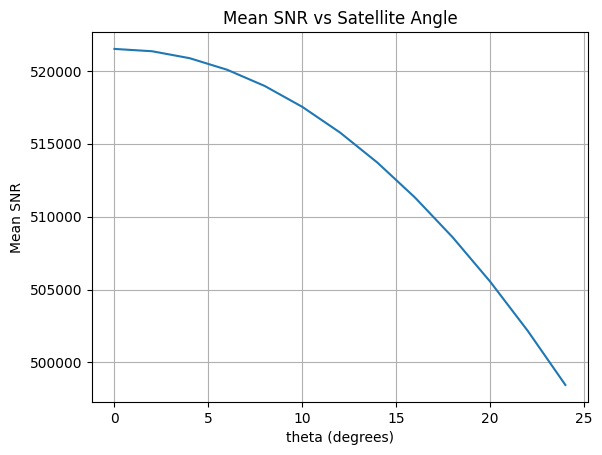

In [ ]:
df_grouped = df.groupby('theta')['SNR'].mean().reset_index()

plt.plot(df_grouped['theta'], df_grouped['SNR'])
plt.xlabel("theta (degrees)")
plt.ylabel("Mean SNR")
plt.title("Mean SNR vs Satellite Angle")
plt.grid(True)
plt.show()

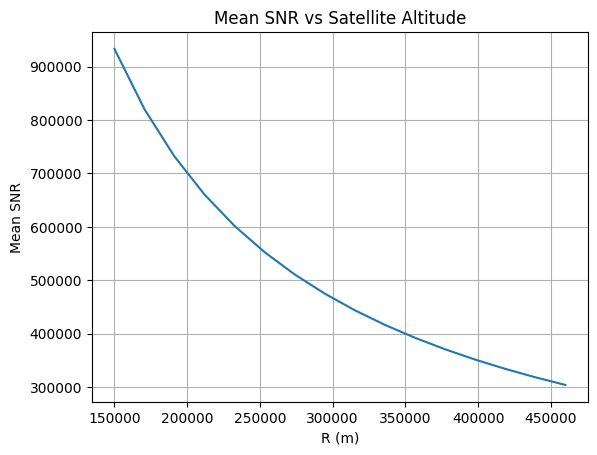

In [ ]:
df_grouped = df.groupby('R')['SNR'].mean().reset_index()

plt.plot(df_grouped['R'], df_grouped['SNR'])
plt.xlabel("R (m)")
plt.ylabel("Mean SNR")
plt.title("Mean SNR vs Satellite Altitude")
plt.grid(True)
plt.show()

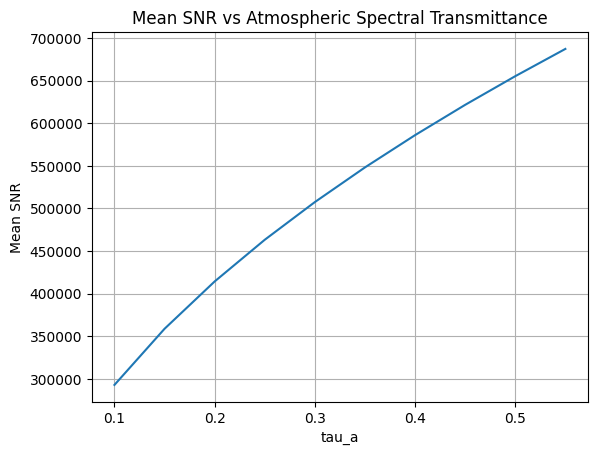

In [ ]:
df_grouped = df.groupby('tau_a')['SNR'].mean().reset_index()

plt.plot(df_grouped['tau_a'], df_grouped['SNR'])
plt.xlabel("tau_a")
plt.ylabel("Mean SNR")
plt.title("Mean SNR vs Atmospheric Spectral Transmittance")
plt.grid(True)
plt.show()

In [ ]:
df_final.columns

Index(['Tg', 'Tf', 'theta', 'R', 'tau_a', 'GSD', 'SNR'], dtype='object')

In [ ]:
fig = px.scatter_3d(df.sample(10000), x='Tg', y='R', z='SNR',
                    color='SNR', title="SNR vs Tg and R")
fig.show()


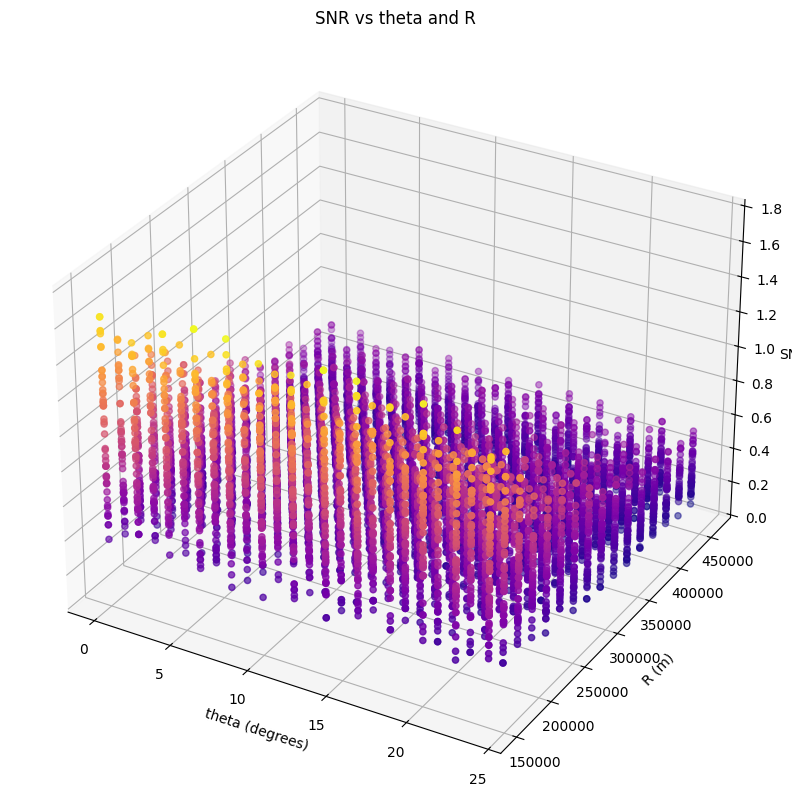

In [ ]:
df_plot = df.sample(10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_plot['theta'], df_plot['R'], df_plot['SNR'], c=df_plot['SNR'], cmap='plasma')
ax.set_xlabel('theta (degrees)')
ax.set_ylabel('R (m)')
ax.set_zlabel('SNR')
plt.title('SNR vs theta and R')
plt.show()


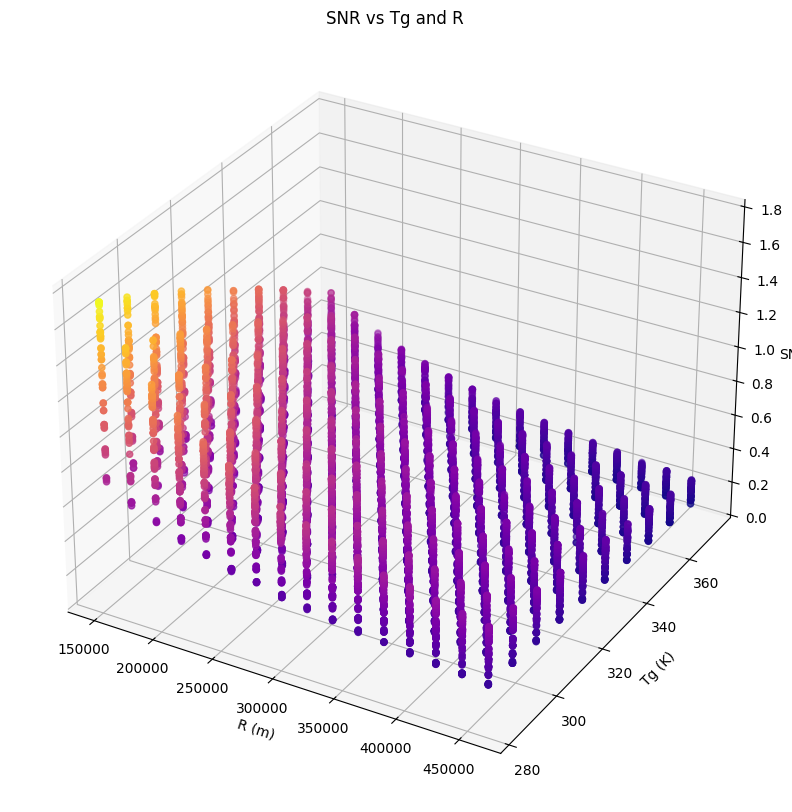

In [ ]:
df_plot = df.sample(10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter( df_plot['R'], df_plot['Tg'], df_plot['SNR'], c=df_plot['SNR'], cmap='plasma')
ax.set_ylabel('Tg (K)')
ax.set_xlabel('R (m)')
ax.set_zlabel('SNR')
plt.title('SNR vs Tg and R')
plt.show()

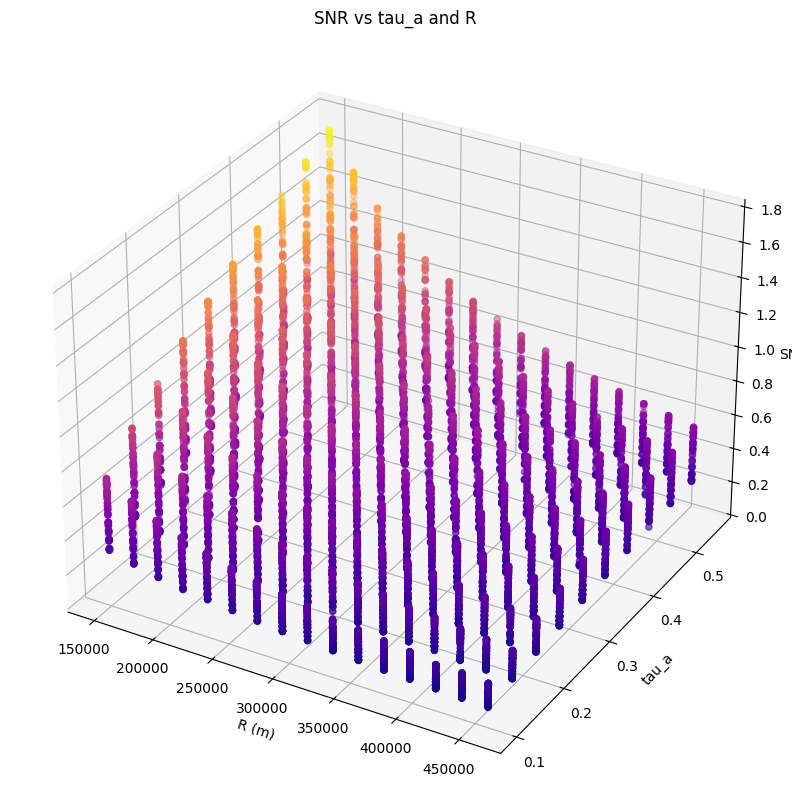

In [ ]:
df_plot = df.sample(10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_plot['R'], df_plot['tau_a'] , df_plot['SNR'], c=df_plot['SNR'], cmap='plasma')
ax.set_ylabel('tau_a')
ax.set_xlabel('R (m)')
ax.set_zlabel('SNR')
plt.title('SNR vs tau_a and R')
plt.show()

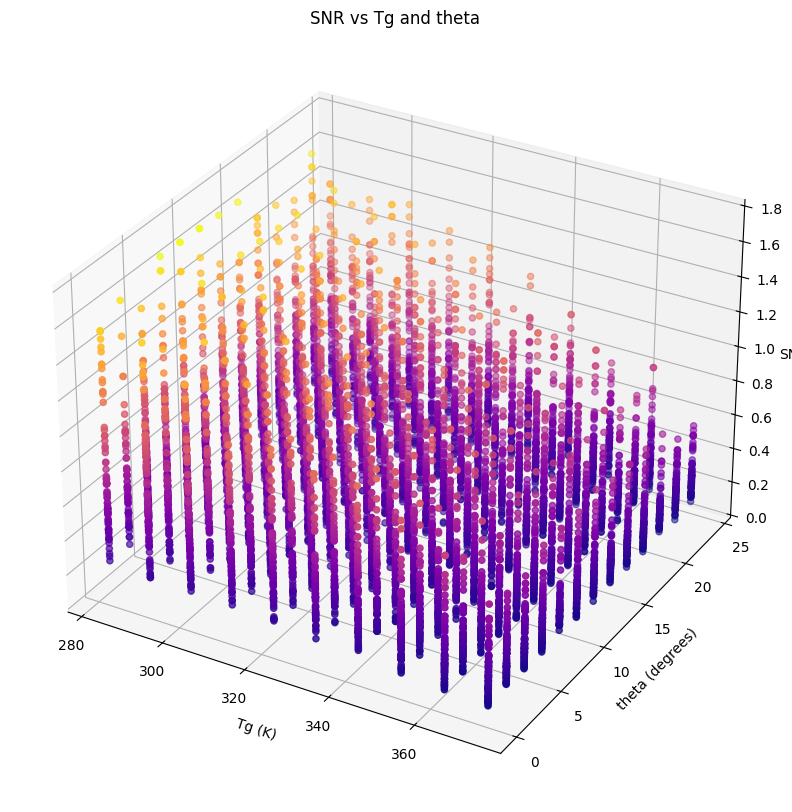

In [ ]:
df_plot = df.sample(10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_plot['Tg'], df_plot['theta'], df_plot['SNR'], c=df_plot['SNR'], cmap='plasma')
ax.set_xlabel('Tg (K)')
ax.set_ylabel('theta (degrees)')
ax.set_zlabel('SNR')
plt.title('SNR vs Tg and theta')
plt.show()

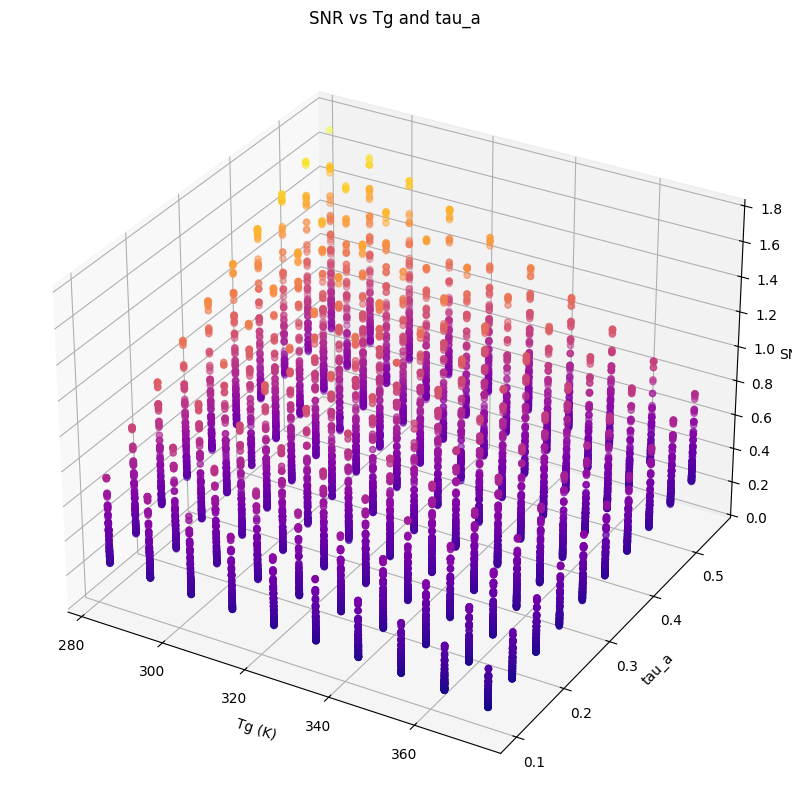

In [ ]:
df_plot = df.sample(10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_plot['Tg'], df_plot['tau_a'], df_plot['SNR'], c=df_plot['SNR'], cmap='plasma')
ax.set_xlabel('Tg (K)')
ax.set_ylabel('tau_a')
ax.set_zlabel('SNR')
plt.title('SNR vs Tg and tau_a')
plt.show()

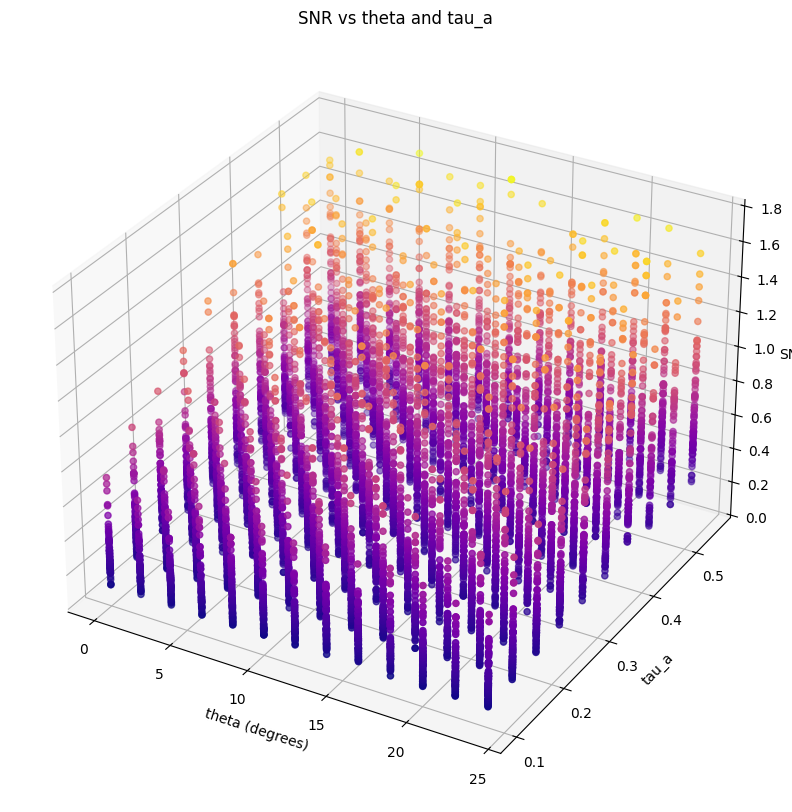

In [ ]:
df_plot = df.sample(10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_plot['theta'], df_plot['tau_a'], df_plot['SNR'], c=df_plot['SNR'], cmap='plasma')
ax.set_xlabel('theta (degrees)')
ax.set_ylabel('tau_a')
ax.set_zlabel('SNR')
plt.title('SNR vs theta and tau_a')
plt.show()

In [ ]:
print(df_final['SNR'].max())

1722280.2035165797


In [ ]:
print(df_final['SNR'].mean())

513526.2852108802
